# Install and Import Dependencies


Most of the project dependencies are installed and necessary modules are imported from the libraries.

- <u>tensorflow</u>: for defining and training the machine learning model
- <u>numpy</u>: for numerical operations, array handling and data manipulation and processing
- <u>opencv-python</u>: for frame processing
- <u>matplotlib</u>: for visualization of data and create graphs of results
- <u>mediapipe</u>: for extraction of landmarks of hands, pose and face from frames
- <u>sckit-learn</u>: for evaluation of model using confusion matrix, roc curve and auc 
- <u>tqdm</u>: for creating progress bars to visualize progress during data processing and training
- <u>fasttext-wheel</u>: for encoding labels to vectors 
- <u>seaborn</u>: for plotting the confusion matrix
- <u>threading</u>: for task parallelization during landmark extraction


In [1]:
pip install -q --upgrade tensorflow

Note: you may need to restart the kernel to use updated packages.


In [2]:
pip install -q opencv-python numpy matplotlib mediapipe scikit-learn tqdm fasttext-wheel seaborn tensorflow

Note: you may need to restart the kernel to use updated packages.


In [3]:
import cv2
import numpy as np
import gc
import os
from matplotlib import pyplot as plt
import shutil
import threading
import mediapipe as mp
import json
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense
from tqdm import tqdm
import fasttext
import fasttext.util
from sklearn.metrics import confusion_matrix
import seaborn as sns
from sklearn.metrics import roc_curve, auc
from sklearn.preprocessing import label_binarize
from itertools import cycle

# Load dataset


A base directory is defined which will be used throughout project to ensure the directory can be changed if required. 

The contents of **WLASL_v0.3.json** is stored in a variable `data` which is used for extracting labels for the video and categorizing input data into train, test and validation split. 

Next the `data` variable is checked to see if it has instantiated properly. 

**missing.txt** is opened in `` to check which videos are missing from the dataset provided to skip processing for missing videos. 

Afterwards the variables used for file reading are discarded and garbage collect the memory no longer in use. This is done in multiple places throughout the project to ensure efficient memory usage and prevent MemoryError.

In [4]:
# defining a base directory to the dataset folder
main_path = './dataset/'
# opening the json file for read
with open(main_path + 'WLASL_v0.3.json', 'r') as json_file:
    data = json.load(json_file)

In [5]:
# checking to see if data has loaded properly
len(data[0]['instances'])

40

In [6]:
# opening the file in read mode
with open(main_path + 'missing.txt', 'r') as file:
    # Reads all lines from the file and stores them in a list
    missing_video_ids = [line.strip() for line in file.readlines()]

# Now, 'lines' contains an array of strings, where each element is a line from the file
print(missing_video_ids)

[]


In [7]:
del file, json_file
gc.collect()

0

# Create Labels and Features


The `data` is processed to extract the labels and data required for creating feature.

- Each unique gesture in `data` is iterated.
- For each word, it is checked if the video listed is missing based on the `missing_video_ids` achieved from **missing.txt** file. 
- If video is available, the start frame, end frame, category (test, train or split), corresponding label and video name is stored.
- These lists are stored for further data processing later on. 
- The progress and data count is checked at the end to ensure all data samples were included - a total of 21083 samples with 2000 labels.

In [8]:
gloss_list = []
video_name_list = []
start_frame = []
end_frame = []
category_list = []
vid_dir = main_path + '/videos'
progress = 0
data_count = 0

# looping through each word / gesture
for word in data:
    # getting the all instances of each word for easy testing of code
    for i in range(len(word['instances'])):

        # if video is missing, skip it
        if any(word["instances"][i]["video_id"] in line for line in missing_video_ids):
            continue

        # get the video path
        vid_name = os.path.join(
            vid_dir, f'{word["instances"][i]["video_id"]}.mp4')

        # get the start, end frame and the label
        start = word['instances'][i]['frame_start']
        end = word['instances'][i]['frame_end']
        label = word['gloss']
        category = word['instances'][i]['split']

        # adding to the list
        video_name_list.append(vid_name)
        gloss_list.append(label)
        start_frame.append(start)
        end_frame.append(end)
        category_list.append(category)

        # updating progress after each loop
        progress += 1
        data_count += 1

print(data_count)

21083


In [9]:
unique_words_count = len(set(gloss_list))
print(
    f'number of unique words = {unique_words_count}\nnumber of videos = {len(video_name_list)}')
print(video_name_list)

number of unique words = 2000
number of videos = 21083
['./dataset//videos\\69241.mp4', './dataset//videos\\65225.mp4', './dataset//videos\\68011.mp4', './dataset//videos\\68208.mp4', './dataset//videos\\68012.mp4', './dataset//videos\\70212.mp4', './dataset//videos\\70266.mp4', './dataset//videos\\07085.mp4', './dataset//videos\\07086.mp4', './dataset//videos\\07087.mp4', './dataset//videos\\07069.mp4', './dataset//videos\\07088.mp4', './dataset//videos\\07089.mp4', './dataset//videos\\07090.mp4', './dataset//videos\\07091.mp4', './dataset//videos\\07092.mp4', './dataset//videos\\07093.mp4', './dataset//videos\\07068.mp4', './dataset//videos\\07094.mp4', './dataset//videos\\07095.mp4', './dataset//videos\\07096.mp4', './dataset//videos\\07097.mp4', './dataset//videos\\07070.mp4', './dataset//videos\\07098.mp4', './dataset//videos\\07099.mp4', './dataset//videos\\07071.mp4', './dataset//videos\\07072.mp4', './dataset//videos\\07073.mp4', './dataset//videos\\67424.mp4', './dataset//vide

In [10]:
del data, unique_words_count, word, progress
gc.collect()

0

# Collect Keypoint Values From Videos


### Extracting Keypoints From A Frame


**Landmarks**

- **Hands:** 42 (21 on each hand)
- **Pose:** 6 landmarks for the upper body excluding the face
- **Face:** 132 out of the 478 landmarks, focusing on the lips, eyes, eyebrows, and the outline of the face
- **Total number of landmarks:** 180, each with coordinates (x, y, z)


In [11]:
filtered_face = [0, 4, 7, 8, 10, 13, 14, 17, 21, 33, 37, 39, 40, 46, 52, 53, 54, 55, 58,
                 61, 63, 65, 66, 67, 70, 78, 80, 81, 82, 84, 87, 88, 91, 93, 95, 103, 105,
                 107, 109, 127, 132, 133, 136, 144, 145, 146, 148, 149, 150, 152, 153, 154,
                 155, 157, 158, 159, 160, 161, 162, 163, 172, 173, 176, 178, 181, 185, 191,
                 234, 246, 249, 251, 263, 267, 269, 270, 276, 282, 283, 284, 285, 288, 291,
                 293, 295, 296, 297, 300, 308, 310, 311, 312, 314, 317, 318, 321, 323, 324,
                 332, 334, 336, 338, 356, 361, 362, 365, 373, 374, 375, 377, 378, 379, 380,
                 381, 382, 384, 385, 386, 387, 388, 389, 390, 397, 398, 400, 402, 405, 409,
                 415, 454, 466, 468, 473]

filtered_pose = [11, 12, 13, 14, 15, 16]

FACE_NUM = len(filtered_face)
POSE_NUM = len(filtered_pose)
HAND_NUM = 21  # per hand

#### Centering The Landmarks


`adjust_3d_landmarks` takes a set of coordinates and centers them by subtracting each 3D coordinates from the specified center. The array containing the set of coordinates is reshaped first to perform the centering on the whole array. 

In [12]:
def adjust_3d_landmarks(arr, center):
    # the array reshaped to have shape (n*m, 3)
    arr_reshaped = arr.reshape(-1, 3)

    # the center array repeated to have shape (n*m, 3)
    center_repeated = np.tile(center, (len(arr_reshaped), 1))

    # the center array subtracted from the arr array
    arr_adjusted = arr_reshaped - center_repeated

    # arr_adjusted reshaped back to shape (n, m, 3)
    arr_adjusted = arr_adjusted.reshape(arr.shape)

    return arr_adjusted

#### Mediapipe Implementation

The function takes in a frame and extracts landmarks from it using MediaPipe's landmark extraction models for tracking hands, pose and face.

- First, instances of the MediaPipe models are created
- `get_frame_landmarks` function takes in a video frame as a parameter and extract landmarks for hands, pose and hands using additional functions.
- `get_hands`, `get_pose` and `get_face` processes the frame using the instances of MediaPipe models created earlier.
- The obtained landmarks are filtered to include the landmarks that were chosen to be included. 
- `adjust_3d_landmarks` is called at the end of each of these three functions to center the landmarks.
- The functions store the adjusted landmarks in their respective indices in an array `all_landmarks`
- Threading is used here to perform these extraction concurrently for efficiency.
- At the end of landmark extraction when threads have finished executing, `all_landmarks` are returned in a single array by the function.  

In [13]:
# instances created for hand, pose and face tracking
hands = mp.solutions.hands.Hands()

pose = mp.solutions.pose.Pose()

face_mesh = mp.solutions.face_mesh.FaceMesh(refine_landmarks=True)



def get_frame_landmarks(frame):
    # 3d array to store landmark for each frame
    all_landmarks = np.zeros((HAND_NUM * 2 + POSE_NUM + FACE_NUM, 3))

    def get_hands(frame):
        results_hands = hands.process(frame)
        if results_hands.multi_hand_landmarks:
            # print("HAND:")
            # print(results_hands.multi_hand_landmarks)
            # iterate over each set of hand landmarks

            for i, hand_landmarks in enumerate(results_hands.multi_hand_landmarks):
                # left hand = 0, right hand = 1
                # left hand

                if results_hands.multi_handedness[i].classification[0].index == 0:
                    hands_landmarks = np.array([(lm.x, lm.y, lm.z) for lm in hand_landmarks.landmark])
                    hands_center = hands_landmarks[0, :3]

                    hands_adjusted = adjust_3d_landmarks(hands_landmarks, hands_center)
                    all_landmarks[:HAND_NUM, :] = hands_adjusted

                else:  # right hand

                    hands_landmarks = np.array([(lm.x, lm.y, lm.z) for lm in hand_landmarks.landmark])
                    hands_center = hands_landmarks[0, :3]

                    hands_adjusted = adjust_3d_landmarks(hands_landmarks, hands_center)
                    all_landmarks[HAND_NUM:HAND_NUM * 2, :] = hands_adjusted

            # print("HAND:")
            # print(hands_adjusted)


    def get_pose(frame):
        results_pose = pose.process(frame)

        if results_pose.pose_landmarks:
            # print("POSE: ")
            # print(results_pose.pose_landmarks)
            poses_landmarks = np.array([(lm.x, lm.y, lm.z) for lm in results_pose.pose_landmarks.landmark])[filtered_pose]
            pose_center = poses_landmarks[0, :3]

            pose_adjusted = adjust_3d_landmarks(poses_landmarks, pose_center)
            all_landmarks[HAND_NUM * 2:HAND_NUM * 2 + POSE_NUM, :] = pose_adjusted

    def get_face(frame):
        results_face = face_mesh.process(frame)
        if results_face.multi_face_landmarks:
            # print("FACE: ")
            # print(results_face.multi_face_landmarks)

            face = np.array([(lm.x, lm.y, lm.z) for lm in results_face.multi_face_landmarks[0].landmark])[filtered_face]
            face_center = face[0, :3]

            face_adjusted = adjust_3d_landmarks(face, face_center)
            all_landmarks[HAND_NUM * 2 + POSE_NUM:, :] = face_adjusted


    # threading for concurrent operation on all 3 landmark locations for each frame
    threads = []
    threads.append(threading.Thread(target=get_hands, args=(frame,)))
    threads.append(threading.Thread(target=get_pose, args=(frame,)))
    threads.append(threading.Thread(target=get_face, args=(frame,)))

    for thread in threads:
        thread.start()

    for thread in threads:
        thread.join()

    return all_landmarks

### Extracting Keypoints From A Video


`get_video_landmarks` processes a video frame by frame to obtain all landmarks for one single video. 

- The function takes a video path, its start and end frame as parameters and opens the specificied video file using OpenCV. 
- If the `start_frame` or `end_frame` is out of bounds, it is adjusted accordingly. The `start_frame` is set to 1 and `end_frame` is set to the frame count of the video obtained by OpenCV.
- An array `all_frame_landmarks` is initialized which will be used to store all the landmarks for a video.
- Using OpenCV, the video frames are iterated.
- The color format is converted from BGR to RGB as MediaPipe works with RGB images.
- The frame is then passed as parameter to the previously defined `get_frame_landmarks` function to obtain landmarks for that frame.
- Obtained landmarks are stored in the `all_frame_landmarks` array and the video capture object is released so resources are freed up.
- The models are reset for the processing of next video processing.
- The landmarks are then returned by function.

In [14]:
def get_video_landmarks(video_path, start_frame=1, end_frame=-1):
    cap = cv2.VideoCapture(video_path)

    # check if start frame less than 1
    if start_frame <= 1:
        start_frame = 1
    # if the start frame exceeds the maximum number of frames
    elif start_frame > int(cap.get(cv2.CAP_PROP_FRAME_COUNT)):
        start_frame = 1
        end_frame = int(cap.get(cv2.CAP_PROP_FRAME_COUNT)) # set to maximum

    # if the final frame was not given (-1)
    if end_frame < 0:
        # end frame = max frame
        end_frame = int(cap.get(cv2.CAP_PROP_FRAME_COUNT))

    num_landmarks = HAND_NUM * 2 + POSE_NUM + FACE_NUM
    all_frame_landmarks = np.zeros((end_frame - start_frame + 1, num_landmarks, 3))
    frame_index = 1

    while cap.isOpened() and frame_index <= end_frame:
        # ret returns value which indicates if frame was properly read or not
        ret, frame = cap.read()
        if not ret: 
            break
        # frames before start frame are skipped
        if frame_index >= start_frame:
            frame.flags.writeable = False
            frame = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
            frame_landmarks = get_frame_landmarks(frame)
            all_frame_landmarks[frame_index - start_frame] = frame_landmarks

        frame_index += 1

    # the video capture object is released
    cap.release()
    
    # the state of the hands, pose, and face_mesh models is reset
    hands.reset()
    pose.reset()
    face_mesh.reset()
    return all_frame_landmarks

# Collecting And Saving Keypoints


### Encoding And Saving Data


Landmarks obtained are set up to be stored in numpy format in specific directories depending on their categorization (train, validation or test split). 

The functions defined previously are called to obtain the landmarks and store them in respective directories as numpy arrays in **.npy** format.
- Each data sample is iterated and a `npy_path` is set based on its split category.
- Before extracting landmarks, it is checked if the npy file already exists. if it does, then it skips that data sample.
- The video path, start frame and end frame is collected from the lists created at the beginning of the project and are passed as parameters to the function `get_video_landmarks` to get the 3D landmarks for the specified video. 
- The landmarks is stored as a numpy file at the path specified by `npy_path`
- A message is printed to indicate that the numpy was saved successfully.  

In [15]:
# storing the keypoints in a folder
numpy_dir = main_path + 'new_preprocessed-data'
if not os.path.exists(numpy_dir):
    os.mkdir(numpy_dir)

numpy_dir_1 = numpy_dir + '/train'
numpy_dir_2 = numpy_dir + '/val'
numpy_dir_3 = numpy_dir + '/test'

if not os.path.exists(numpy_dir_1):
    os.mkdir(numpy_dir_1)
if not os.path.exists(numpy_dir_2):
    os.mkdir(numpy_dir_2)
if not os.path.exists(numpy_dir_3):
    os.mkdir(numpy_dir_3)

In [16]:
# data_count is the number of dataset

for i in tqdm(range(data_count), ncols=100):
    # specify the path for the test npy to be saved
    npy_path = f'{main_path}new_preprocessed-data/{category_list[i]}/{i}.npy'

    # Check if the file already exists
    if os.path.exists(npy_path):
        print(f"File {npy_path} already exists..")
        continue

    # getting the video information
    input_path = video_name_list[i]
    start = start_frame[i]
    end = end_frame[i]

    # getting the landmarks for the specified frame range
    npyArray = get_video_landmarks(input_path, start, end)
    # print(npyArray)

    # saving the file
    np.save(npy_path, npyArray)
    print(f"{category_list[i]}/{i}.npy has been saved")

  0%|                                                            | 16/21083 [00:00<04:20, 80.86it/s]

File ./dataset/new_preprocessed-data/train/0.npy already exists..
File ./dataset/new_preprocessed-data/train/1.npy already exists..
File ./dataset/new_preprocessed-data/train/2.npy already exists..
File ./dataset/new_preprocessed-data/train/3.npy already exists..
File ./dataset/new_preprocessed-data/train/4.npy already exists..
File ./dataset/new_preprocessed-data/val/5.npy already exists..
File ./dataset/new_preprocessed-data/train/6.npy already exists..
File ./dataset/new_preprocessed-data/train/7.npy already exists..
File ./dataset/new_preprocessed-data/train/8.npy already exists..
File ./dataset/new_preprocessed-data/train/9.npy already exists..
File ./dataset/new_preprocessed-data/train/10.npy already exists..
File ./dataset/new_preprocessed-data/train/11.npy already exists..
File ./dataset/new_preprocessed-data/train/12.npy already exists..
File ./dataset/new_preprocessed-data/train/13.npy already exists..
File ./dataset/new_preprocessed-data/train/14.npy already exists..
File ./

  0%|▏                                                          | 58/21083 [00:00<02:00, 173.94it/s]

File ./dataset/new_preprocessed-data/train/25.npy already exists..
File ./dataset/new_preprocessed-data/test/26.npy already exists..
File ./dataset/new_preprocessed-data/train/27.npy already exists..
File ./dataset/new_preprocessed-data/train/28.npy already exists..
File ./dataset/new_preprocessed-data/train/29.npy already exists..
File ./dataset/new_preprocessed-data/train/30.npy already exists..
File ./dataset/new_preprocessed-data/train/31.npy already exists..
File ./dataset/new_preprocessed-data/train/32.npy already exists..
File ./dataset/new_preprocessed-data/train/33.npy already exists..
File ./dataset/new_preprocessed-data/train/34.npy already exists..
File ./dataset/new_preprocessed-data/train/35.npy already exists..
File ./dataset/new_preprocessed-data/train/36.npy already exists..
File ./dataset/new_preprocessed-data/train/37.npy already exists..
File ./dataset/new_preprocessed-data/val/38.npy already exists..
File ./dataset/new_preprocessed-data/train/39.npy already exists.

  1%|▍                                                         | 157/21083 [00:00<00:59, 349.59it/s]

File ./dataset/new_preprocessed-data/test/86.npy already exists..
File ./dataset/new_preprocessed-data/train/87.npy already exists..
File ./dataset/new_preprocessed-data/train/88.npy already exists..
File ./dataset/new_preprocessed-data/train/89.npy already exists..
File ./dataset/new_preprocessed-data/train/90.npy already exists..
File ./dataset/new_preprocessed-data/train/91.npy already exists..
File ./dataset/new_preprocessed-data/val/92.npy already exists..
File ./dataset/new_preprocessed-data/train/93.npy already exists..
File ./dataset/new_preprocessed-data/train/94.npy already exists..
File ./dataset/new_preprocessed-data/train/95.npy already exists..
File ./dataset/new_preprocessed-data/train/96.npy already exists..
File ./dataset/new_preprocessed-data/test/97.npy already exists..
File ./dataset/new_preprocessed-data/test/98.npy already exists..
File ./dataset/new_preprocessed-data/train/99.npy already exists..
File ./dataset/new_preprocessed-data/train/100.npy already exists..

  1%|▋                                                         | 261/21083 [00:00<00:46, 445.40it/s]

File ./dataset/new_preprocessed-data/train/182.npy already exists..
File ./dataset/new_preprocessed-data/test/183.npy already exists..
File ./dataset/new_preprocessed-data/train/184.npy already exists..
File ./dataset/new_preprocessed-data/train/185.npy already exists..
File ./dataset/new_preprocessed-data/train/186.npy already exists..
File ./dataset/new_preprocessed-data/train/187.npy already exists..
File ./dataset/new_preprocessed-data/train/188.npy already exists..
File ./dataset/new_preprocessed-data/train/189.npy already exists..
File ./dataset/new_preprocessed-data/train/190.npy already exists..
File ./dataset/new_preprocessed-data/test/191.npy already exists..
File ./dataset/new_preprocessed-data/train/192.npy already exists..
File ./dataset/new_preprocessed-data/train/193.npy already exists..
File ./dataset/new_preprocessed-data/val/194.npy already exists..
File ./dataset/new_preprocessed-data/val/195.npy already exists..
File ./dataset/new_preprocessed-data/train/196.npy alr

  2%|█▎                                                        | 462/21083 [00:01<00:28, 713.76it/s]

File ./dataset/new_preprocessed-data/train/361.npy already exists..
File ./dataset/new_preprocessed-data/val/362.npy already exists..
File ./dataset/new_preprocessed-data/train/363.npy already exists..
File ./dataset/new_preprocessed-data/train/364.npy already exists..
File ./dataset/new_preprocessed-data/train/365.npy already exists..
File ./dataset/new_preprocessed-data/train/366.npy already exists..
File ./dataset/new_preprocessed-data/train/367.npy already exists..
File ./dataset/new_preprocessed-data/train/368.npy already exists..
File ./dataset/new_preprocessed-data/train/369.npy already exists..
File ./dataset/new_preprocessed-data/val/370.npy already exists..
File ./dataset/new_preprocessed-data/train/371.npy already exists..
File ./dataset/new_preprocessed-data/train/372.npy already exists..
File ./dataset/new_preprocessed-data/train/373.npy already exists..
File ./dataset/new_preprocessed-data/train/374.npy already exists..
File ./dataset/new_preprocessed-data/train/375.npy a

  3%|█▉                                                        | 703/21083 [00:01<00:21, 938.06it/s]

File ./dataset/new_preprocessed-data/train/561.npy already exists..
File ./dataset/new_preprocessed-data/test/562.npy already exists..
File ./dataset/new_preprocessed-data/train/563.npy already exists..
File ./dataset/new_preprocessed-data/test/564.npy already exists..
File ./dataset/new_preprocessed-data/train/565.npy already exists..
File ./dataset/new_preprocessed-data/train/566.npy already exists..
File ./dataset/new_preprocessed-data/train/567.npy already exists..
File ./dataset/new_preprocessed-data/test/568.npy already exists..
File ./dataset/new_preprocessed-data/val/569.npy already exists..
File ./dataset/new_preprocessed-data/train/570.npy already exists..
File ./dataset/new_preprocessed-data/val/571.npy already exists..
File ./dataset/new_preprocessed-data/val/572.npy already exists..
File ./dataset/new_preprocessed-data/train/573.npy already exists..
File ./dataset/new_preprocessed-data/train/574.npy already exists..
File ./dataset/new_preprocessed-data/train/575.npy alread

  5%|███                                                     | 1147/21083 [00:01<00:12, 1557.18it/s]

File ./dataset/new_preprocessed-data/train/817.npy already exists..
File ./dataset/new_preprocessed-data/train/818.npy already exists..
File ./dataset/new_preprocessed-data/train/819.npy already exists..
File ./dataset/new_preprocessed-data/train/820.npy already exists..
File ./dataset/new_preprocessed-data/train/821.npy already exists..
File ./dataset/new_preprocessed-data/train/822.npy already exists..
File ./dataset/new_preprocessed-data/train/823.npy already exists..
File ./dataset/new_preprocessed-data/val/824.npy already exists..
File ./dataset/new_preprocessed-data/train/825.npy already exists..
File ./dataset/new_preprocessed-data/val/826.npy already exists..
File ./dataset/new_preprocessed-data/train/827.npy already exists..
File ./dataset/new_preprocessed-data/test/828.npy already exists..
File ./dataset/new_preprocessed-data/train/829.npy already exists..
File ./dataset/new_preprocessed-data/train/830.npy already exists..
File ./dataset/new_preprocessed-data/train/831.npy al

  7%|███▉                                                    | 1500/21083 [00:01<00:11, 1643.29it/s]

File ./dataset/new_preprocessed-data/train/1258.npy already exists..
File ./dataset/new_preprocessed-data/train/1259.npy already exists..
File ./dataset/new_preprocessed-data/test/1260.npy already exists..
File ./dataset/new_preprocessed-data/train/1261.npy already exists..
File ./dataset/new_preprocessed-data/test/1262.npy already exists..
File ./dataset/new_preprocessed-data/val/1263.npy already exists..
File ./dataset/new_preprocessed-data/test/1264.npy already exists..
File ./dataset/new_preprocessed-data/val/1265.npy already exists..
File ./dataset/new_preprocessed-data/train/1266.npy already exists..
File ./dataset/new_preprocessed-data/train/1267.npy already exists..
File ./dataset/new_preprocessed-data/train/1268.npy already exists..
File ./dataset/new_preprocessed-data/test/1269.npy already exists..
File ./dataset/new_preprocessed-data/train/1270.npy already exists..
File ./dataset/new_preprocessed-data/train/1271.npy already exists..
File ./dataset/new_preprocessed-data/train

  9%|████▉                                                   | 1862/21083 [00:01<00:11, 1698.17it/s]

File ./dataset/new_preprocessed-data/train/1602.npy already exists..
File ./dataset/new_preprocessed-data/train/1603.npy already exists..
File ./dataset/new_preprocessed-data/train/1604.npy already exists..
File ./dataset/new_preprocessed-data/train/1605.npy already exists..
File ./dataset/new_preprocessed-data/val/1606.npy already exists..
File ./dataset/new_preprocessed-data/train/1607.npy already exists..
File ./dataset/new_preprocessed-data/train/1608.npy already exists..
File ./dataset/new_preprocessed-data/train/1609.npy already exists..
File ./dataset/new_preprocessed-data/test/1610.npy already exists..
File ./dataset/new_preprocessed-data/train/1611.npy already exists..
File ./dataset/new_preprocessed-data/train/1612.npy already exists..
File ./dataset/new_preprocessed-data/train/1613.npy already exists..
File ./dataset/new_preprocessed-data/val/1614.npy already exists..
File ./dataset/new_preprocessed-data/train/1615.npy already exists..
File ./dataset/new_preprocessed-data/tr

 11%|█████▉                                                  | 2214/21083 [00:02<00:12, 1530.99it/s]

File ./dataset/new_preprocessed-data/train/1980.npy already exists..
File ./dataset/new_preprocessed-data/val/1981.npy already exists..
File ./dataset/new_preprocessed-data/train/1982.npy already exists..
File ./dataset/new_preprocessed-data/train/1983.npy already exists..
File ./dataset/new_preprocessed-data/test/1984.npy already exists..
File ./dataset/new_preprocessed-data/test/1985.npy already exists..
File ./dataset/new_preprocessed-data/train/1986.npy already exists..
File ./dataset/new_preprocessed-data/train/1987.npy already exists..
File ./dataset/new_preprocessed-data/train/1988.npy already exists..
File ./dataset/new_preprocessed-data/val/1989.npy already exists..
File ./dataset/new_preprocessed-data/train/1990.npy already exists..
File ./dataset/new_preprocessed-data/train/1991.npy already exists..
File ./dataset/new_preprocessed-data/val/1992.npy already exists..
File ./dataset/new_preprocessed-data/train/1993.npy already exists..
File ./dataset/new_preprocessed-data/train

 11%|██████▎                                                 | 2371/21083 [00:02<00:14, 1321.73it/s]

File ./dataset/new_preprocessed-data/train/2250.npy already exists..
File ./dataset/new_preprocessed-data/val/2251.npy already exists..
File ./dataset/new_preprocessed-data/val/2252.npy already exists..
File ./dataset/new_preprocessed-data/train/2253.npy already exists..
File ./dataset/new_preprocessed-data/train/2254.npy already exists..
File ./dataset/new_preprocessed-data/train/2255.npy already exists..
File ./dataset/new_preprocessed-data/train/2256.npy already exists..
File ./dataset/new_preprocessed-data/val/2257.npy already exists..
File ./dataset/new_preprocessed-data/train/2258.npy already exists..
File ./dataset/new_preprocessed-data/train/2259.npy already exists..
File ./dataset/new_preprocessed-data/train/2260.npy already exists..
File ./dataset/new_preprocessed-data/train/2261.npy already exists..
File ./dataset/new_preprocessed-data/train/2262.npy already exists..
File ./dataset/new_preprocessed-data/train/2263.npy already exists..
File ./dataset/new_preprocessed-data/tes

 13%|███████                                                 | 2660/21083 [00:02<00:13, 1375.18it/s]

File ./dataset/new_preprocessed-data/train/2505.npy already exists..
File ./dataset/new_preprocessed-data/val/2506.npy already exists..
File ./dataset/new_preprocessed-data/val/2507.npy already exists..
File ./dataset/new_preprocessed-data/train/2508.npy already exists..
File ./dataset/new_preprocessed-data/train/2509.npy already exists..
File ./dataset/new_preprocessed-data/train/2510.npy already exists..
File ./dataset/new_preprocessed-data/train/2511.npy already exists..
File ./dataset/new_preprocessed-data/val/2512.npy already exists..
File ./dataset/new_preprocessed-data/train/2513.npy already exists..
File ./dataset/new_preprocessed-data/train/2514.npy already exists..
File ./dataset/new_preprocessed-data/train/2515.npy already exists..
File ./dataset/new_preprocessed-data/train/2516.npy already exists..
File ./dataset/new_preprocessed-data/train/2517.npy already exists..
File ./dataset/new_preprocessed-data/train/2518.npy already exists..
File ./dataset/new_preprocessed-data/tes

 14%|███████▉                                                | 2966/21083 [00:02<00:12, 1446.21it/s]

File ./dataset/new_preprocessed-data/train/2794.npy already exists..
File ./dataset/new_preprocessed-data/train/2795.npy already exists..
File ./dataset/new_preprocessed-data/train/2796.npy already exists..
File ./dataset/new_preprocessed-data/train/2797.npy already exists..
File ./dataset/new_preprocessed-data/val/2798.npy already exists..
File ./dataset/new_preprocessed-data/train/2799.npy already exists..
File ./dataset/new_preprocessed-data/train/2800.npy already exists..
File ./dataset/new_preprocessed-data/train/2801.npy already exists..
File ./dataset/new_preprocessed-data/train/2802.npy already exists..
File ./dataset/new_preprocessed-data/test/2803.npy already exists..
File ./dataset/new_preprocessed-data/val/2804.npy already exists..
File ./dataset/new_preprocessed-data/train/2805.npy already exists..
File ./dataset/new_preprocessed-data/train/2806.npy already exists..
File ./dataset/new_preprocessed-data/train/2807.npy already exists..
File ./dataset/new_preprocessed-data/tr

 16%|████████▊                                               | 3301/21083 [00:02<00:12, 1478.25it/s]

File ./dataset/new_preprocessed-data/val/3085.npy already exists..
File ./dataset/new_preprocessed-data/train/3086.npy already exists..
File ./dataset/new_preprocessed-data/train/3087.npy already exists..
File ./dataset/new_preprocessed-data/train/3088.npy already exists..
File ./dataset/new_preprocessed-data/train/3089.npy already exists..
File ./dataset/new_preprocessed-data/test/3090.npy already exists..
File ./dataset/new_preprocessed-data/train/3091.npy already exists..
File ./dataset/new_preprocessed-data/val/3092.npy already exists..
File ./dataset/new_preprocessed-data/train/3093.npy already exists..
File ./dataset/new_preprocessed-data/train/3094.npy already exists..
File ./dataset/new_preprocessed-data/train/3095.npy already exists..
File ./dataset/new_preprocessed-data/train/3096.npy already exists..
File ./dataset/new_preprocessed-data/train/3097.npy already exists..
File ./dataset/new_preprocessed-data/train/3098.npy already exists..
File ./dataset/new_preprocessed-data/va

 17%|█████████▋                                              | 3643/21083 [00:03<00:11, 1578.41it/s]

File ./dataset/new_preprocessed-data/val/3421.npy already exists..
File ./dataset/new_preprocessed-data/train/3422.npy already exists..
File ./dataset/new_preprocessed-data/train/3423.npy already exists..
File ./dataset/new_preprocessed-data/val/3424.npy already exists..
File ./dataset/new_preprocessed-data/train/3425.npy already exists..
File ./dataset/new_preprocessed-data/train/3426.npy already exists..
File ./dataset/new_preprocessed-data/train/3427.npy already exists..
File ./dataset/new_preprocessed-data/train/3428.npy already exists..
File ./dataset/new_preprocessed-data/train/3429.npy already exists..
File ./dataset/new_preprocessed-data/test/3430.npy already exists..
File ./dataset/new_preprocessed-data/val/3431.npy already exists..
File ./dataset/new_preprocessed-data/test/3432.npy already exists..
File ./dataset/new_preprocessed-data/train/3433.npy already exists..
File ./dataset/new_preprocessed-data/train/3434.npy already exists..
File ./dataset/new_preprocessed-data/train

 19%|██████████▌                                             | 3967/21083 [00:03<00:12, 1395.34it/s]

File ./dataset/new_preprocessed-data/val/3784.npy already exists..
File ./dataset/new_preprocessed-data/train/3785.npy already exists..
File ./dataset/new_preprocessed-data/train/3786.npy already exists..
File ./dataset/new_preprocessed-data/train/3787.npy already exists..
File ./dataset/new_preprocessed-data/train/3788.npy already exists..
File ./dataset/new_preprocessed-data/train/3789.npy already exists..
File ./dataset/new_preprocessed-data/test/3790.npy already exists..
File ./dataset/new_preprocessed-data/val/3791.npy already exists..
File ./dataset/new_preprocessed-data/test/3792.npy already exists..
File ./dataset/new_preprocessed-data/train/3793.npy already exists..
File ./dataset/new_preprocessed-data/train/3794.npy already exists..
File ./dataset/new_preprocessed-data/train/3795.npy already exists..
File ./dataset/new_preprocessed-data/val/3796.npy already exists..
File ./dataset/new_preprocessed-data/train/3797.npy already exists..
File ./dataset/new_preprocessed-data/train

 20%|██████████▉                                             | 4112/21083 [00:03<00:13, 1260.14it/s]

File ./dataset/new_preprocessed-data/train/3992.npy already exists..
File ./dataset/new_preprocessed-data/train/3993.npy already exists..
File ./dataset/new_preprocessed-data/val/3994.npy already exists..
File ./dataset/new_preprocessed-data/train/3995.npy already exists..
File ./dataset/new_preprocessed-data/train/3996.npy already exists..
File ./dataset/new_preprocessed-data/train/3997.npy already exists..
File ./dataset/new_preprocessed-data/train/3998.npy already exists..
File ./dataset/new_preprocessed-data/train/3999.npy already exists..
File ./dataset/new_preprocessed-data/test/4000.npy already exists..
File ./dataset/new_preprocessed-data/val/4001.npy already exists..
File ./dataset/new_preprocessed-data/test/4002.npy already exists..
File ./dataset/new_preprocessed-data/train/4003.npy already exists..
File ./dataset/new_preprocessed-data/train/4004.npy already exists..
File ./dataset/new_preprocessed-data/train/4005.npy already exists..
File ./dataset/new_preprocessed-data/val

 21%|███████████▌                                            | 4375/21083 [00:03<00:13, 1246.14it/s]

File ./dataset/new_preprocessed-data/train/4217.npy already exists..
File ./dataset/new_preprocessed-data/train/4218.npy already exists..
File ./dataset/new_preprocessed-data/val/4219.npy already exists..
File ./dataset/new_preprocessed-data/train/4220.npy already exists..
File ./dataset/new_preprocessed-data/train/4221.npy already exists..
File ./dataset/new_preprocessed-data/train/4222.npy already exists..
File ./dataset/new_preprocessed-data/train/4223.npy already exists..
File ./dataset/new_preprocessed-data/train/4224.npy already exists..
File ./dataset/new_preprocessed-data/test/4225.npy already exists..
File ./dataset/new_preprocessed-data/val/4226.npy already exists..
File ./dataset/new_preprocessed-data/test/4227.npy already exists..
File ./dataset/new_preprocessed-data/train/4228.npy already exists..
File ./dataset/new_preprocessed-data/train/4229.npy already exists..
File ./dataset/new_preprocessed-data/train/4230.npy already exists..
File ./dataset/new_preprocessed-data/val

 22%|████████████▎                                           | 4621/21083 [00:03<00:14, 1123.91it/s]

File ./dataset/new_preprocessed-data/train/4450.npy already exists..
File ./dataset/new_preprocessed-data/train/4451.npy already exists..
File ./dataset/new_preprocessed-data/train/4452.npy already exists..
File ./dataset/new_preprocessed-data/test/4453.npy already exists..
File ./dataset/new_preprocessed-data/train/4454.npy already exists..
File ./dataset/new_preprocessed-data/train/4455.npy already exists..
File ./dataset/new_preprocessed-data/val/4456.npy already exists..
File ./dataset/new_preprocessed-data/train/4457.npy already exists..
File ./dataset/new_preprocessed-data/train/4458.npy already exists..
File ./dataset/new_preprocessed-data/val/4459.npy already exists..
File ./dataset/new_preprocessed-data/train/4460.npy already exists..
File ./dataset/new_preprocessed-data/train/4461.npy already exists..
File ./dataset/new_preprocessed-data/train/4462.npy already exists..
File ./dataset/new_preprocessed-data/train/4463.npy already exists..
File ./dataset/new_preprocessed-data/tr

 22%|████████████▌                                           | 4736/21083 [00:04<00:16, 1011.96it/s]

File ./dataset/new_preprocessed-data/test/4664.npy already exists..
File ./dataset/new_preprocessed-data/val/4665.npy already exists..
File ./dataset/new_preprocessed-data/test/4666.npy already exists..
File ./dataset/new_preprocessed-data/train/4667.npy already exists..
File ./dataset/new_preprocessed-data/train/4668.npy already exists..
File ./dataset/new_preprocessed-data/train/4669.npy already exists..
File ./dataset/new_preprocessed-data/train/4670.npy already exists..
File ./dataset/new_preprocessed-data/train/4671.npy already exists..
File ./dataset/new_preprocessed-data/val/4672.npy already exists..
File ./dataset/new_preprocessed-data/train/4673.npy already exists..
File ./dataset/new_preprocessed-data/train/4674.npy already exists..
File ./dataset/new_preprocessed-data/train/4675.npy already exists..
File ./dataset/new_preprocessed-data/train/4676.npy already exists..
File ./dataset/new_preprocessed-data/train/4677.npy already exists..
File ./dataset/new_preprocessed-data/tes

 23%|█████████████▎                                           | 4936/21083 [00:04<00:18, 895.85it/s]

File ./dataset/new_preprocessed-data/train/4821.npy already exists..
File ./dataset/new_preprocessed-data/train/4822.npy already exists..
File ./dataset/new_preprocessed-data/val/4823.npy already exists..
File ./dataset/new_preprocessed-data/test/4824.npy already exists..
File ./dataset/new_preprocessed-data/train/4825.npy already exists..
File ./dataset/new_preprocessed-data/train/4826.npy already exists..
File ./dataset/new_preprocessed-data/test/4827.npy already exists..
File ./dataset/new_preprocessed-data/train/4828.npy already exists..
File ./dataset/new_preprocessed-data/train/4829.npy already exists..
File ./dataset/new_preprocessed-data/train/4830.npy already exists..
File ./dataset/new_preprocessed-data/train/4831.npy already exists..
File ./dataset/new_preprocessed-data/val/4832.npy already exists..
File ./dataset/new_preprocessed-data/train/4833.npy already exists..
File ./dataset/new_preprocessed-data/train/4834.npy already exists..
File ./dataset/new_preprocessed-data/tra

 24%|█████████████▉                                           | 5133/21083 [00:04<00:17, 896.03it/s]

File ./dataset/new_preprocessed-data/test/5002.npy already exists..
File ./dataset/new_preprocessed-data/train/5003.npy already exists..
File ./dataset/new_preprocessed-data/train/5004.npy already exists..
File ./dataset/new_preprocessed-data/train/5005.npy already exists..
File ./dataset/new_preprocessed-data/train/5006.npy already exists..
File ./dataset/new_preprocessed-data/train/5007.npy already exists..
File ./dataset/new_preprocessed-data/val/5008.npy already exists..
File ./dataset/new_preprocessed-data/train/5009.npy already exists..
File ./dataset/new_preprocessed-data/train/5010.npy already exists..
File ./dataset/new_preprocessed-data/train/5011.npy already exists..
File ./dataset/new_preprocessed-data/train/5012.npy already exists..
File ./dataset/new_preprocessed-data/train/5013.npy already exists..
File ./dataset/new_preprocessed-data/test/5014.npy already exists..
File ./dataset/new_preprocessed-data/val/5015.npy already exists..
File ./dataset/new_preprocessed-data/tes

 25%|██████████████▍                                          | 5350/21083 [00:04<00:16, 964.58it/s]

File ./dataset/new_preprocessed-data/train/5188.npy already exists..
File ./dataset/new_preprocessed-data/train/5189.npy already exists..
File ./dataset/new_preprocessed-data/val/5190.npy already exists..
File ./dataset/new_preprocessed-data/train/5191.npy already exists..
File ./dataset/new_preprocessed-data/train/5192.npy already exists..
File ./dataset/new_preprocessed-data/train/5193.npy already exists..
File ./dataset/new_preprocessed-data/train/5194.npy already exists..
File ./dataset/new_preprocessed-data/train/5195.npy already exists..
File ./dataset/new_preprocessed-data/test/5196.npy already exists..
File ./dataset/new_preprocessed-data/val/5197.npy already exists..
File ./dataset/new_preprocessed-data/test/5198.npy already exists..
File ./dataset/new_preprocessed-data/train/5199.npy already exists..
File ./dataset/new_preprocessed-data/train/5200.npy already exists..
File ./dataset/new_preprocessed-data/train/5201.npy already exists..
File ./dataset/new_preprocessed-data/tra

 26%|██████████████▊                                         | 5573/21083 [00:05<00:15, 1028.30it/s]

File ./dataset/new_preprocessed-data/test/5436.npy already exists..
File ./dataset/new_preprocessed-data/train/5437.npy already exists..
File ./dataset/new_preprocessed-data/train/5438.npy already exists..
File ./dataset/new_preprocessed-data/train/5439.npy already exists..
File ./dataset/new_preprocessed-data/train/5440.npy already exists..
File ./dataset/new_preprocessed-data/test/5441.npy already exists..
File ./dataset/new_preprocessed-data/train/5442.npy already exists..
File ./dataset/new_preprocessed-data/train/5443.npy already exists..
File ./dataset/new_preprocessed-data/train/5444.npy already exists..
File ./dataset/new_preprocessed-data/val/5445.npy already exists..
File ./dataset/new_preprocessed-data/val/5446.npy already exists..
File ./dataset/new_preprocessed-data/val/5447.npy already exists..
File ./dataset/new_preprocessed-data/train/5448.npy already exists..
File ./dataset/new_preprocessed-data/train/5449.npy already exists..
File ./dataset/new_preprocessed-data/test/

 28%|███████████████▍                                        | 5806/21083 [00:05<00:13, 1103.59it/s]

File ./dataset/new_preprocessed-data/test/5658.npy already exists..
File ./dataset/new_preprocessed-data/val/5659.npy already exists..
File ./dataset/new_preprocessed-data/test/5660.npy already exists..
File ./dataset/new_preprocessed-data/train/5661.npy already exists..
File ./dataset/new_preprocessed-data/train/5662.npy already exists..
File ./dataset/new_preprocessed-data/train/5663.npy already exists..
File ./dataset/new_preprocessed-data/train/5664.npy already exists..
File ./dataset/new_preprocessed-data/train/5665.npy already exists..
File ./dataset/new_preprocessed-data/val/5666.npy already exists..
File ./dataset/new_preprocessed-data/train/5667.npy already exists..
File ./dataset/new_preprocessed-data/train/5668.npy already exists..
File ./dataset/new_preprocessed-data/train/5669.npy already exists..
File ./dataset/new_preprocessed-data/train/5670.npy already exists..
File ./dataset/new_preprocessed-data/train/5671.npy already exists..
File ./dataset/new_preprocessed-data/tes

 29%|████████████████▍                                       | 6170/21083 [00:05<00:10, 1386.33it/s]

File ./dataset/new_preprocessed-data/train/5981.npy already exists..
File ./dataset/new_preprocessed-data/test/5982.npy already exists..
File ./dataset/new_preprocessed-data/train/5983.npy already exists..
File ./dataset/new_preprocessed-data/test/5984.npy already exists..
File ./dataset/new_preprocessed-data/val/5985.npy already exists..
File ./dataset/new_preprocessed-data/val/5986.npy already exists..
File ./dataset/new_preprocessed-data/train/5987.npy already exists..
File ./dataset/new_preprocessed-data/train/5988.npy already exists..
File ./dataset/new_preprocessed-data/train/5989.npy already exists..
File ./dataset/new_preprocessed-data/train/5990.npy already exists..
File ./dataset/new_preprocessed-data/train/5991.npy already exists..
File ./dataset/new_preprocessed-data/train/5992.npy already exists..
File ./dataset/new_preprocessed-data/train/5993.npy already exists..
File ./dataset/new_preprocessed-data/train/5994.npy already exists..
File ./dataset/new_preprocessed-data/tes

 31%|█████████████████▌                                      | 6599/21083 [00:05<00:08, 1707.00it/s]

File ./dataset/new_preprocessed-data/train/6273.npy already exists..
File ./dataset/new_preprocessed-data/train/6274.npy already exists..
File ./dataset/new_preprocessed-data/train/6275.npy already exists..
File ./dataset/new_preprocessed-data/train/6276.npy already exists..
File ./dataset/new_preprocessed-data/train/6277.npy already exists..
File ./dataset/new_preprocessed-data/train/6278.npy already exists..
File ./dataset/new_preprocessed-data/train/6279.npy already exists..
File ./dataset/new_preprocessed-data/train/6280.npy already exists..
File ./dataset/new_preprocessed-data/test/6281.npy already exists..
File ./dataset/new_preprocessed-data/train/6282.npy already exists..
File ./dataset/new_preprocessed-data/test/6283.npy already exists..
File ./dataset/new_preprocessed-data/val/6284.npy already exists..
File ./dataset/new_preprocessed-data/val/6285.npy already exists..
File ./dataset/new_preprocessed-data/test/6286.npy already exists..
File ./dataset/new_preprocessed-data/trai

 32%|█████████████████▉                                      | 6770/21083 [00:05<00:09, 1507.79it/s]

File ./dataset/new_preprocessed-data/test/6671.npy already exists..
File ./dataset/new_preprocessed-data/train/6672.npy already exists..
File ./dataset/new_preprocessed-data/test/6673.npy already exists..
File ./dataset/new_preprocessed-data/val/6674.npy already exists..
File ./dataset/new_preprocessed-data/val/6675.npy already exists..
File ./dataset/new_preprocessed-data/train/6676.npy already exists..
File ./dataset/new_preprocessed-data/train/6677.npy already exists..
File ./dataset/new_preprocessed-data/train/6678.npy already exists..
File ./dataset/new_preprocessed-data/train/6679.npy already exists..
File ./dataset/new_preprocessed-data/train/6680.npy already exists..
File ./dataset/new_preprocessed-data/train/6681.npy already exists..
File ./dataset/new_preprocessed-data/train/6682.npy already exists..
File ./dataset/new_preprocessed-data/train/6683.npy already exists..
File ./dataset/new_preprocessed-data/test/6684.npy already exists..
File ./dataset/new_preprocessed-data/trai

 34%|██████████████████▊                                     | 7099/21083 [00:06<00:09, 1459.27it/s]

File ./dataset/new_preprocessed-data/train/6902.npy already exists..
File ./dataset/new_preprocessed-data/train/6903.npy already exists..
File ./dataset/new_preprocessed-data/train/6904.npy already exists..
File ./dataset/new_preprocessed-data/test/6905.npy already exists..
File ./dataset/new_preprocessed-data/train/6906.npy already exists..
File ./dataset/new_preprocessed-data/test/6907.npy already exists..
File ./dataset/new_preprocessed-data/val/6908.npy already exists..
File ./dataset/new_preprocessed-data/val/6909.npy already exists..
File ./dataset/new_preprocessed-data/train/6910.npy already exists..
File ./dataset/new_preprocessed-data/train/6911.npy already exists..
File ./dataset/new_preprocessed-data/train/6912.npy already exists..
File ./dataset/new_preprocessed-data/train/6913.npy already exists..
File ./dataset/new_preprocessed-data/train/6914.npy already exists..
File ./dataset/new_preprocessed-data/train/6915.npy already exists..
File ./dataset/new_preprocessed-data/tra

 39%|█████████████████████▉                                  | 8242/21083 [00:06<00:03, 3361.17it/s]

File ./dataset/new_preprocessed-data/train/7715.npy already exists..
File ./dataset/new_preprocessed-data/train/7716.npy already exists..
File ./dataset/new_preprocessed-data/val/7717.npy already exists..
File ./dataset/new_preprocessed-data/train/7718.npy already exists..
File ./dataset/new_preprocessed-data/train/7719.npy already exists..
File ./dataset/new_preprocessed-data/train/7720.npy already exists..
File ./dataset/new_preprocessed-data/train/7721.npy already exists..
File ./dataset/new_preprocessed-data/val/7722.npy already exists..
File ./dataset/new_preprocessed-data/test/7723.npy already exists..
File ./dataset/new_preprocessed-data/test/7724.npy already exists..
File ./dataset/new_preprocessed-data/train/7725.npy already exists..
File ./dataset/new_preprocessed-data/train/7726.npy already exists..
File ./dataset/new_preprocessed-data/train/7727.npy already exists..
File ./dataset/new_preprocessed-data/train/7728.npy already exists..
File ./dataset/new_preprocessed-data/val

 52%|████████████████████████████▍                          | 10880/21083 [00:06<00:01, 8311.46it/s]

File ./dataset/new_preprocessed-data/train/9368.npy already exists..
File ./dataset/new_preprocessed-data/test/9369.npy already exists..
File ./dataset/new_preprocessed-data/train/9370.npy already exists..
File ./dataset/new_preprocessed-data/train/9371.npy already exists..
File ./dataset/new_preprocessed-data/train/9372.npy already exists..
File ./dataset/new_preprocessed-data/train/9373.npy already exists..
File ./dataset/new_preprocessed-data/val/9374.npy already exists..
File ./dataset/new_preprocessed-data/test/9375.npy already exists..
File ./dataset/new_preprocessed-data/train/9376.npy already exists..
File ./dataset/new_preprocessed-data/train/9377.npy already exists..
File ./dataset/new_preprocessed-data/val/9378.npy already exists..
File ./dataset/new_preprocessed-data/train/9379.npy already exists..
File ./dataset/new_preprocessed-data/test/9380.npy already exists..
File ./dataset/new_preprocessed-data/train/9381.npy already exists..
File ./dataset/new_preprocessed-data/trai

 59%|████████████████████████████████▋                      | 12532/21083 [00:06<00:01, 7273.59it/s]

File ./dataset/new_preprocessed-data/val/11675.npy already exists..
File ./dataset/new_preprocessed-data/train/11676.npy already exists..
File ./dataset/new_preprocessed-data/train/11677.npy already exists..
File ./dataset/new_preprocessed-data/test/11678.npy already exists..
File ./dataset/new_preprocessed-data/train/11679.npy already exists..
File ./dataset/new_preprocessed-data/train/11680.npy already exists..
File ./dataset/new_preprocessed-data/train/11681.npy already exists..
File ./dataset/new_preprocessed-data/train/11682.npy already exists..
File ./dataset/new_preprocessed-data/val/11683.npy already exists..
File ./dataset/new_preprocessed-data/train/11684.npy already exists..
File ./dataset/new_preprocessed-data/val/11685.npy already exists..
File ./dataset/new_preprocessed-data/train/11686.npy already exists..
File ./dataset/new_preprocessed-data/train/11687.npy already exists..
File ./dataset/new_preprocessed-data/test/11688.npy already exists..
File ./dataset/new_preproces

 63%|██████████████████████████████████▋                    | 13282/21083 [00:06<00:01, 5978.32it/s]

File ./dataset/new_preprocessed-data/test/13026.npy already exists..
File ./dataset/new_preprocessed-data/train/13027.npy already exists..
File ./dataset/new_preprocessed-data/train/13028.npy already exists..
File ./dataset/new_preprocessed-data/train/13029.npy already exists..
File ./dataset/new_preprocessed-data/train/13030.npy already exists..
File ./dataset/new_preprocessed-data/val/13031.npy already exists..
File ./dataset/new_preprocessed-data/train/13032.npy already exists..
File ./dataset/new_preprocessed-data/val/13033.npy already exists..
File ./dataset/new_preprocessed-data/train/13034.npy already exists..
File ./dataset/new_preprocessed-data/train/13035.npy already exists..
File ./dataset/new_preprocessed-data/test/13036.npy already exists..
File ./dataset/new_preprocessed-data/train/13037.npy already exists..
File ./dataset/new_preprocessed-data/train/13038.npy already exists..
File ./dataset/new_preprocessed-data/train/13039.npy already exists..
File ./dataset/new_preproc

 71%|███████████████████████████████████████                | 14976/21083 [00:07<00:00, 6703.07it/s]

File ./dataset/new_preprocessed-data/train/13720.npy already exists..
File ./dataset/new_preprocessed-data/train/13721.npy already exists..
File ./dataset/new_preprocessed-data/train/13722.npy already exists..
File ./dataset/new_preprocessed-data/train/13723.npy already exists..
File ./dataset/new_preprocessed-data/val/13724.npy already exists..
File ./dataset/new_preprocessed-data/val/13725.npy already exists..
File ./dataset/new_preprocessed-data/train/13726.npy already exists..
File ./dataset/new_preprocessed-data/test/13727.npy already exists..
File ./dataset/new_preprocessed-data/train/13728.npy already exists..
File ./dataset/new_preprocessed-data/train/13729.npy already exists..
File ./dataset/new_preprocessed-data/train/13730.npy already exists..
File ./dataset/new_preprocessed-data/train/13731.npy already exists..
File ./dataset/new_preprocessed-data/train/13732.npy already exists..
File ./dataset/new_preprocessed-data/val/13733.npy already exists..
File ./dataset/new_preproce

 74%|████████████████████████████████████████▉              | 15677/21083 [00:07<00:00, 5695.43it/s]

File ./dataset/new_preprocessed-data/train/15267.npy already exists..
File ./dataset/new_preprocessed-data/train/15268.npy already exists..
File ./dataset/new_preprocessed-data/train/15269.npy already exists..
File ./dataset/new_preprocessed-data/train/15270.npy already exists..
File ./dataset/new_preprocessed-data/val/15271.npy already exists..
File ./dataset/new_preprocessed-data/val/15272.npy already exists..
File ./dataset/new_preprocessed-data/train/15273.npy already exists..
File ./dataset/new_preprocessed-data/test/15274.npy already exists..
File ./dataset/new_preprocessed-data/train/15275.npy already exists..
File ./dataset/new_preprocessed-data/train/15276.npy already exists..
File ./dataset/new_preprocessed-data/train/15277.npy already exists..
File ./dataset/new_preprocessed-data/train/15278.npy already exists..
File ./dataset/new_preprocessed-data/train/15279.npy already exists..
File ./dataset/new_preprocessed-data/val/15280.npy already exists..
File ./dataset/new_preproce

 77%|██████████████████████████████████████████▍            | 16288/21083 [00:07<00:01, 4542.93it/s]

File ./dataset/new_preprocessed-data/train/15942.npy already exists..
File ./dataset/new_preprocessed-data/val/15943.npy already exists..
File ./dataset/new_preprocessed-data/test/15944.npy already exists..
File ./dataset/new_preprocessed-data/train/15945.npy already exists..
File ./dataset/new_preprocessed-data/train/15946.npy already exists..
File ./dataset/new_preprocessed-data/train/15947.npy already exists..
File ./dataset/new_preprocessed-data/val/15948.npy already exists..
File ./dataset/new_preprocessed-data/train/15949.npy already exists..
File ./dataset/new_preprocessed-data/train/15950.npy already exists..
File ./dataset/new_preprocessed-data/val/15951.npy already exists..
File ./dataset/new_preprocessed-data/test/15952.npy already exists..
File ./dataset/new_preprocessed-data/train/15953.npy already exists..
File ./dataset/new_preprocessed-data/train/15954.npy already exists..
File ./dataset/new_preprocessed-data/train/15955.npy already exists..
File ./dataset/new_preproces

 80%|███████████████████████████████████████████▊           | 16800/21083 [00:07<00:00, 4317.30it/s]

File ./dataset/new_preprocessed-data/val/16563.npy already exists..
File ./dataset/new_preprocessed-data/train/16564.npy already exists..
File ./dataset/new_preprocessed-data/train/16565.npy already exists..
File ./dataset/new_preprocessed-data/val/16566.npy already exists..
File ./dataset/new_preprocessed-data/test/16567.npy already exists..
File ./dataset/new_preprocessed-data/train/16568.npy already exists..
File ./dataset/new_preprocessed-data/train/16569.npy already exists..
File ./dataset/new_preprocessed-data/train/16570.npy already exists..
File ./dataset/new_preprocessed-data/val/16571.npy already exists..
File ./dataset/new_preprocessed-data/train/16572.npy already exists..
File ./dataset/new_preprocessed-data/train/16573.npy already exists..
File ./dataset/new_preprocessed-data/val/16574.npy already exists..
File ./dataset/new_preprocessed-data/test/16575.npy already exists..
File ./dataset/new_preprocessed-data/train/16576.npy already exists..
File ./dataset/new_preprocesse

 84%|██████████████████████████████████████████████▏        | 17720/21083 [00:07<00:00, 4040.92it/s]

File ./dataset/new_preprocessed-data/train/17252.npy already exists..
File ./dataset/new_preprocessed-data/train/17253.npy already exists..
File ./dataset/new_preprocessed-data/val/17254.npy already exists..
File ./dataset/new_preprocessed-data/test/17255.npy already exists..
File ./dataset/new_preprocessed-data/train/17256.npy already exists..
File ./dataset/new_preprocessed-data/train/17257.npy already exists..
File ./dataset/new_preprocessed-data/train/17258.npy already exists..
File ./dataset/new_preprocessed-data/val/17259.npy already exists..
File ./dataset/new_preprocessed-data/train/17260.npy already exists..
File ./dataset/new_preprocessed-data/train/17261.npy already exists..
File ./dataset/new_preprocessed-data/val/17262.npy already exists..
File ./dataset/new_preprocessed-data/test/17263.npy already exists..
File ./dataset/new_preprocessed-data/train/17264.npy already exists..
File ./dataset/new_preprocessed-data/train/17265.npy already exists..
File ./dataset/new_preproces

 89%|████████████████████████████████████████████████▊      | 18715/21083 [00:08<00:00, 4133.39it/s]

File ./dataset/new_preprocessed-data/train/18242.npy already exists..
File ./dataset/new_preprocessed-data/train/18243.npy already exists..
File ./dataset/new_preprocessed-data/val/18244.npy already exists..
File ./dataset/new_preprocessed-data/test/18245.npy already exists..
File ./dataset/new_preprocessed-data/train/18246.npy already exists..
File ./dataset/new_preprocessed-data/train/18247.npy already exists..
File ./dataset/new_preprocessed-data/train/18248.npy already exists..
File ./dataset/new_preprocessed-data/val/18249.npy already exists..
File ./dataset/new_preprocessed-data/train/18250.npy already exists..
File ./dataset/new_preprocessed-data/train/18251.npy already exists..
File ./dataset/new_preprocessed-data/val/18252.npy already exists..
File ./dataset/new_preprocessed-data/test/18253.npy already exists..
File ./dataset/new_preprocessed-data/train/18254.npy already exists..
File ./dataset/new_preprocessed-data/train/18255.npy already exists..
File ./dataset/new_preproces

 94%|███████████████████████████████████████████████████▋   | 19821/21083 [00:08<00:00, 4526.44it/s]

File ./dataset/new_preprocessed-data/val/18991.npy already exists..
File ./dataset/new_preprocessed-data/train/18992.npy already exists..
File ./dataset/new_preprocessed-data/train/18993.npy already exists..
File ./dataset/new_preprocessed-data/train/18994.npy already exists..
File ./dataset/new_preprocessed-data/train/18995.npy already exists..
File ./dataset/new_preprocessed-data/train/18996.npy already exists..
File ./dataset/new_preprocessed-data/test/18997.npy already exists..
File ./dataset/new_preprocessed-data/val/18998.npy already exists..
File ./dataset/new_preprocessed-data/train/18999.npy already exists..
File ./dataset/new_preprocessed-data/train/19000.npy already exists..
File ./dataset/new_preprocessed-data/train/19001.npy already exists..
File ./dataset/new_preprocessed-data/train/19002.npy already exists..
File ./dataset/new_preprocessed-data/train/19003.npy already exists..
File ./dataset/new_preprocessed-data/test/19004.npy already exists..
File ./dataset/new_preproc

100%|███████████████████████████████████████████████████████| 21083/21083 [00:08<00:00, 2455.97it/s]

File ./dataset/new_preprocessed-data/train/20064.npy already exists..
File ./dataset/new_preprocessed-data/train/20065.npy already exists..
File ./dataset/new_preprocessed-data/train/20066.npy already exists..
File ./dataset/new_preprocessed-data/train/20067.npy already exists..
File ./dataset/new_preprocessed-data/test/20068.npy already exists..
File ./dataset/new_preprocessed-data/val/20069.npy already exists..
File ./dataset/new_preprocessed-data/train/20070.npy already exists..
File ./dataset/new_preprocessed-data/train/20071.npy already exists..
File ./dataset/new_preprocessed-data/train/20072.npy already exists..
File ./dataset/new_preprocessed-data/train/20073.npy already exists..
File ./dataset/new_preprocessed-data/train/20074.npy already exists..
File ./dataset/new_preprocessed-data/test/20075.npy already exists..
File ./dataset/new_preprocessed-data/val/20076.npy already exists..
File ./dataset/new_preprocessed-data/train/20077.npy already exists..
File ./dataset/new_preproc

### Storing Landmarks According to Split

Three **.npz** files for train, test and validation data are created. These files is used later to obtain the landmark data without performing the process every time, thus saving time. 

The function `generate_npz` takes in a directory path for the npy filepath, a dictionary and the path to save the compressed npz file. Next, each saved numpy array of that particular split is loaded and added to the dictionary. Finally, the dictionary is saved as a compressed npz file. 

`generate_npz` is used for storing training, testing and validation data if the npz does not exist. This saves time by using the previously existing npz file instead of generating each time. 

Next the dictionary are deleted and garbage collector is called to free up memory space. 

In [17]:
train_landmarks_dict = {}
test_landmarks_dict = {}
val_landmarks_dict = {}

train_npy_dir = main_path + 'new_preprocessed-data/train'
test_npy_dir = main_path + 'new_preprocessed-data/test'
val_npy_dir = main_path + 'new_preprocessed-data/val'

In [18]:
# compressed form of landmark files saved
def generate_npz(npy_dir, landmarks_dict, npz_path):
    for filename in os.listdir(npy_dir):
        if filename.endswith('.npy'):
            key = filename.split('.')[0]
            landmarks = np.load(os.path.join(
                npy_dir, filename), allow_pickle=True) # to allow serializing objects
            # print(landmarks)
            landmarks_dict[key] = landmarks
            print(f'{npy_dir}/{filename} added')

    np.savez_compressed(npz_path, **landmarks_dict)
    print(f"{npy_dir} saved successfully")

In [19]:
npz_landmarks_dir = main_path + 'landmarks/'
if not os.path.exists(npz_landmarks_dir):
    os.mkdir(npz_landmarks_dir)

In [20]:
npz_train_path = main_path + 'landmarks/landmarks_train.npz'
npz_test_path = main_path + 'landmarks/landmarks_test.npz'
npz_val_path = main_path + 'landmarks/landmarks_val.npz'

if not os.path.exists(npz_train_path):
    generate_npz(train_npy_dir, train_landmarks_dict, npz_train_path)
if not os.path.exists(npz_test_path):
    generate_npz(test_npy_dir, test_landmarks_dict, npz_test_path)
if not os.path.exists(npz_val_path):
    generate_npz(val_npy_dir, val_landmarks_dict, npz_val_path)

In [21]:
del train_landmarks_dict, test_landmarks_dict, val_landmarks_dict
gc.collect()

9

# Data Loading


This section loads the preprocessed landmarks from the saved compressed npz into `X_train`, `Y_train`, `X_val`, `Y_val`, `X_test` and `Y_test` variables to be used in the model later on. 

`load_data` function is used to load data based on a number of choices. It takes in parameters of filtered labels, a number of labels from the top and a landmark dictionary. The above function is used to load train, validation and test data with a specific number of labels and the loaded landmarks are passed as landmark dictionary. 

Next some print statements are written to check the dimensions of the data and finally, variables no longer required are deleted. 

In [22]:
landmark_train_dict = np.load(
    npz_landmarks_dir + 'landmarks_train.npz', allow_pickle=True)
landmark_test_dict = np.load(
    npz_landmarks_dir + 'landmarks_test.npz', allow_pickle=True)
landmark_val_dict = np.load(
    npz_landmarks_dir + 'landmarks_val.npz', allow_pickle=True)

In [23]:
def load_data(filtered_labels=None, max_labels=None, landmarks_dict=None):

    if filtered_labels is not None:
        X = [landmarks_dict[k] for k in landmarks_dict.keys()
             if gloss_list[int(k)] in filtered_labels]
        Y = [gloss_list[int(k)] for k in landmarks_dict.keys()
             if gloss_list[int(k)] in filtered_labels]
    
    elif max_labels is not None:
        label_counts = {}
        for label in gloss_list:
            label_counts[label] = label_counts.get(label, 0) + 1 # updating label_counts with the count of occurrences for the current label

        top_labels = sorted(label_counts, key=label_counts.get, reverse=True)[:max_labels]
        X = [landmarks_dict[k] for k in landmarks_dict.keys()
             if gloss_list[int(k)] in top_labels]
        Y = [gloss_list[int(k)] for k in landmarks_dict.keys() if gloss_list[int(k)] in top_labels]
        
    else:
        X = [landmarks_dict[k] for k in landmarks_dict.keys()]
        Y = [gloss_list[int(k)] for k in landmarks_dict.keys()]

    return X, Y


In [24]:
X_train, Y_train = load_data(landmarks_dict=landmark_train_dict, max_labels=50)
X_val, Y_val = load_data(landmarks_dict=landmark_val_dict, max_labels=50)
X_test, Y_test = load_data(landmarks_dict=landmark_test_dict, max_labels=50)

In [25]:
len(X_train), len(X_val), len(X_test)

(785, 183, 143)

In [26]:
len(np.unique(Y_train)), len(np.unique(Y_val)), len(np.unique(Y_test))

(50, 50, 50)

In [27]:
# free space
del landmark_train_dict, landmark_test_dict, landmark_val_dict

gc.collect()

539

# Data Augmentation


Data Augmentation methods are employed here to the X and Y variables of train split loaded in previous section. The following augmentation functions are defined:
- rotations: `rotate`, `rotate_x`, `rotate_y` and `rotate_z` are performed to rotate the coordinates of landmarks based on a given rotation matrix, x axis, y axis or z axis respectively. 
- scale: preserves the center and scales the data randomly
- shift: the data is shifted either vertically or horizontally
- mask: a random part of the landmark is masked
- horizontal flip: the data is flipped horizontally
- speedup: the frame is downsized by taking every 2 frames

`apply_augmentations` function applies a a subset of these augmentation functions to the data and finally `augment` function applies a variable number of augmentation to the data. The number of augmentations to be applied can be controlled using this parameter. If no number is specified, then the number of augments is selected randomly.

The augmentation is applied on `X_train` and `Y_train` specifying the number of augmentations to 1 due to limitations of memory that can be allocated. Finally the dimensions are printed to check if augmentation has been applied successfully.

### Rotation Augmentation


In [28]:
# rotate according to given matrix
def rotate(data, rotation_matrix):
    frames, landmarks, _ = data.shape
    center = np.array([0.5, 0.5, 0])
    non_zero = np.argwhere(np.any(data[:, :, :2] != 0, axis=2))
    data = data.reshape(-1, 3)
    data[non_zero] -= center
    data[non_zero] = np.dot(data[non_zero], rotation_matrix.T)
    data[non_zero] += center
    data = data.reshape(frames, landmarks, 3)
    out_of_range = np.any((data[:, :, :2] < 0) | (data[:, :, :2] > 1), axis=2)
    data[out_of_range] = 0
    return data

# rotate around the z axis
def rotate_z(data):
    angle = np.random.choice([np.random.uniform(-15, -5),
                              np.random.uniform(5, 15)])
    theta = np.radians(angle)
    rotation_matrix = np.array([
        [np.cos(theta), -np.sin(theta), 0],
        [np.sin(theta), np.cos(theta), 0],
        [0, 0, 1]
    ])
    return rotate(data, rotation_matrix)

# rotate around the y axis
def rotate_y(data):
    angle = np.random.choice([np.random.uniform(-15, -5),
                              np.random.uniform(5, 15)])
    theta = np.radians(angle)
    rotation_matrix = np.array([
        [np.cos(theta), 0, np.sin(theta)],
        [0, 1, 0],
        [-np.sin(theta), 0, np.cos(theta)]
    ])
    return rotate(data, rotation_matrix)

# rotate around the x axis
def rotate_x(data):
    angle = np.random.choice([np.random.uniform(-15, -5),
                              np.random.uniform(5, 15)])
    theta = np.radians(angle)
    rotation_matrix = np.array([
        [1, 0, 0],
        [0, np.cos(theta), -np.sin(theta)],
        [0, np.sin(theta), np.cos(theta)]
    ])
    return rotate(data, rotation_matrix)

### Other Augmentations


In [29]:
# randomly scales data between 0.8 and 1.2 while preserving center
def zoom(data):
    factor = np.random.uniform(0.8, 1.2)
    center = np.array([0.5, 0.5])
    non_zero = np.argwhere(np.any(data[:, :, :2] != 0, axis=2))
    data[non_zero[:, 0], non_zero[:, 1], :2] = (
        (data[non_zero[:, 0], non_zero[:, 1], :2] - center) * factor + center
    )
    out_of_range = np.any((data[:, :, :2] < 0) | (data[:, :, :2] > 1), axis=2)
    data[out_of_range] = 0
    return data

# randomly shifts the data horizontally and vertically by a small amount
def shift(data):
    x_shift = np.random.uniform(-0.1, 0.1)
    y_shift = np.random.uniform(-0.1, 0.1)
    non_zero = np.argwhere(np.any(data[:, :, :2] != 0, axis=2))
    data[non_zero[:, 0], non_zero[:, 1], 0] += x_shift
    data[non_zero[:, 0], non_zero[:, 1], 1] += y_shift
    out_of_range = np.any((data[:, :, :2] < 0) | (data[:, :, :2] > 1), axis=2)
    data[out_of_range] = 0
    return data


def mask(data):
    frames, landmarks, _ = data.shape
    num_hands = int(0.3 * 42) # 30% landmarks taken from one hand
    num_rest = int(0.6 * (landmarks - 42)) # 60% landmarks taken from other hand

    # boolean mask applied
    mask = np.zeros(landmarks, dtype=bool)
    indices = np.concatenate([
        np.random.choice(42, num_hands, replace=False),
        np.random.choice(landmarks - 42, num_rest, replace=False) + 42
    ])
    mask[indices] = True
    data[:, mask] = 0
    return data

# a horizontal flip
def hflip(data):
    data[:, :, 0] = 1 - data[:, :, 0]
    return data

# downsizing the frame number by taking every 2 frames
def speedup(data):
    return data[::2]

### Applying the Augmentations to the Data


In [30]:
def apply_augmentations(data):
    aug_functions = [rotate_x, rotate_y, rotate_z,
                     zoom, shift, mask, hflip, speedup]
    np.random.shuffle(aug_functions)
    counter = 0
    for fun in aug_functions:
        if np.random.rand() < 0.5:
            data = fun(data)
            counter += 1

    # recursive call to ensure at least one augmentation applied
    if counter == 0:
        data = apply_augmentations(data)

    return data

In [31]:
def augment(X, Y, num=None):
    X_aug = X.copy()
    Y_aug = Y.copy()

    if num is None:
        for i in tqdm(range(len(Y)), ncols=100):
            num_aug = np.random.choice([1, 2, 3])
            for n in range(num_aug):
                X_aug.append(apply_augmentations(X[i].copy()))
                Y_aug.append(Y[i])
    elif num > 0:
        for i in tqdm(range(len(Y)), ncols=100):
            for n in range(num):
                X_aug.append(apply_augmentations(X[i].copy()))
                Y_aug.append(Y[i])

    return X_aug, Y_aug

In [32]:
X_train, Y_train = augment(X_train, Y_train, 1)

100%|████████████████████████████████████████████████████████████| 785/785 [00:07<00:00, 102.11it/s]


In [33]:
len(X_train), len(Y_train)

(1570, 1570)

In [34]:
len(X_train), len(X_train[10]), len(X_train[12][12]), len(X_train[0][0][0])

(1570, 55, 180, 3)

# Data Preprocessing


This section is used to apply padding to the data to ensure the number of frames in all X is equal.

`padding` function pads the sequences in `X` variables for train, validation and test. It takes in the `X`, `Y`, a desired sequence length for padding and a value to use for padding. The padded X is then stored in `X_padded` and converted to numpy array. 

The `padding` function is applied to the input `X` and output `Y` with a specified length of 76 and a padding of -80. The value of 76 was chosen to avoid MemoryError since the arrays take up a lot of space. 

Print statements at the end confirms the data was indeed padded with the specified sequence. 

In [35]:
# only X padded
def padding(X, Y, length=None, pad=0):
    if length is None:
        length = max(len(x) for x in X)

    X_padded = []
    for x in X:
        if len(x) > length:
            X_padded.append(x[:length])  # truncate if more than length
        else:
            pad_length = length - len(x)
            X_padded.append(np.pad(
                x, ((0, pad_length), (0, 0), (0, 0)),
                mode='constant', constant_values=pad
            ))

    X_padded = np.array(X_padded)
    return X_padded, Y

In [36]:
gc.collect()
length = 76
X_train, Y_train = padding(X_train, Y_train, length=length, pad=-80)
X_val, Y_val = padding(X_val, Y_val, length=length, pad=-80)
X_test, Y_test = padding(X_test, Y_test, length=length, pad=-80)

In [37]:
# (videos, frames, landmarks, coordinates)
X_train.shape, X_val.shape, X_test.shape

((1570, 76, 180, 3), (183, 76, 180, 3), (143, 76, 180, 3))

# Build and Train MLP Neural Network


### Label Encoding (Using FastText)

The pre-trained FastText model contains word vectors (embeddings) for English words. This model is used to encode the labels into vectors since cosine similarity function is used later on. 

The model is downloaded onlt if it does not already exist to save time. Otherwise, the downloaded model is loaded into `ft`. 

The existence of saved encoded labels `labels.npz` are checked. If it does not exist, the unique labels are extracted from `Y_train` and encoded using FastText word vectors from the model `ft`. The encoded labels are then saved so this step can be skipped next time.

In [38]:
fasttext.util.download_model('en', if_exists='ignore')
ft = fasttext.load_model('cc.en.300.bin')

In [39]:
# label encoded and compressed version saved
labels = np.unique(Y_train)
print(len(labels))
if not os.path.exists(main_path + f'labels_{len(labels)}.npz'):
    encoded_labels = {label: ft.get_word_vector(label) for label in labels}
    print(encoded_labels)
    np.savez_compressed(main_path + f'labels_{len(labels)}.npz', **encoded_labels)

{'all': array([-5.62025094e-03,  1.23602942e-01,  5.60198948e-02,  1.52056351e-01,
       -8.33222941e-02, -2.05691643e-02, -8.77717286e-02, -3.76699418e-02,
       -8.58359784e-02,  1.87284499e-03,  4.81783524e-02, -1.48703726e-02,
       -5.75469919e-02,  2.75351126e-02,  8.70755687e-03, -1.88273281e-01,
       -2.10712478e-03,  5.53103574e-02, -6.60865307e-02, -5.62950075e-02,
       -1.82443634e-02,  5.15929647e-02, -3.76624651e-02,  9.22834426e-02,
       -1.34721443e-01, -6.41660392e-02, -4.51035425e-03,  3.19677666e-02,
        2.35811695e-02,  1.24521181e-02,  5.00749424e-02, -5.09692281e-02,
       -3.77000012e-02, -1.92067042e-01, -2.02257037e-02, -5.70852347e-02,
        1.77841522e-02,  4.54543494e-02, -9.59120691e-02, -2.68098079e-02,
        1.70395337e-03, -5.85241988e-03,  4.53609042e-03,  9.46265161e-02,
        2.78412141e-02, -1.16653174e-01,  4.83750179e-03, -4.48372513e-02,
       -2.54008919e-05, -1.58590972e-02,  3.56544182e-02, -3.65015492e-02,
        2.7352806

The encoded labels are loaded from the previously generated `labels.npz` into a variable `labels_dict`. 

**Cosine Similarity**

- np.dot(v1, v2): dot product of the two vectors v1 and v2

- (np.linalg.norm(v1) * np.linalg.norm(v2)): product of the Euclidean norms (magnitude) of the two vectors

- The cosine similarity ranges from -1 to 1, where:

    - 1 indicates that the vectors are identical
    - 0 indicates that the vectors are orthogonal (no similarity)
    - -1 indicates that the vectors are diametrically opposed

This is used to test the workings of cosine similarity fucntion.

In [40]:
labels_dict = np.load(main_path + f'labels_{len(labels)}.npz', allow_pickle=True)
print(labels_dict)

NpzFile './dataset/labels.npz' with keys: all, bed, before, black, blue...


In [41]:
def cosine_similarity(v1, v2):
    return np.dot(v1, v2) / (np.linalg.norm(v1) * np.linalg.norm(v2))

In [42]:
word = 'car'
word_vector = ft.get_word_vector(word)
similarity_scores = []
for label, label_vector in labels_dict.items():
    # printing similarity score between 'car' and each label
    similarity_scores.append(cosine_similarity(word_vector, label_vector))

print(similarity_scores)

[0.12677868, 0.26175568, 0.20786922, 0.17653413, 0.17837594, 0.20042694, 0.16298836, 0.14216733, 0.17595138, 0.2784324, 0.30802536, 0.2739488, 0.16121688, 0.25655723, 0.10420053, 0.30997255, 0.26731065, 0.25618508, 0.12267529, 0.18311776, 0.13260205, 0.19900857, 0.11532654, 0.15151018, 0.15011625, 0.14019549, 0.21162584, 0.16453144, 0.099238895, 0.14020996, 0.13727157, 0.27532405, 0.08060868, 0.25757277, 0.11617127, 0.09814612, 0.16611488, 0.19663587, 0.07625091, 0.13496359, 0.06651978, 0.10629105, 0.0061206087, 0.27300304, 0.105295785, 0.15353943, 0.122977614, 0.28127807, 0.09626312, 0.062487416]


In [43]:
del similarity_scores, word, word_vector, ft
gc.collect()

121

### Loading the encoded labels

Next the original `Y_train`, `Y_val` and `Y_test` are replaced with their corresponding FastText word vectors stored in the compressed npz file.

In [44]:
Y_train = np.array([labels_dict[label] for label in Y_train])
Y_val = np.array([labels_dict[label] for label in Y_val])
Y_test = np.array([labels_dict[label] for label in Y_test])

In [45]:
Y_train.shape

(1570, 300)

### Defining Model


In [46]:
tf.keras.backend.clear_session()
physical_devices = tf.config.list_physical_devices('GPU')
for device in physical_devices:
    tf.config.experimental.set_memory_growth(device, True)
physical_devices

[]

This is a feedforward neural network, also known as multi-layer perceptrons (MLPs) with 4 hidden layers.
- Masking Layer at the top ignores the inputs with a value of -80 which is useful for handling padded sequences.
- Flatten layer is used to convert the 3D output from previous layer to 1D array
- Dense Layers of 512 units with ReLU activation are used for extracting features and to introduce non-linearity
- Batch Normalization are applied after dense layer to normalize the activations
- Dropout Layers after each batch normalization ensures that regulatization is applied so overfitting does not occur. The rate is set to 0.3 for two layers and 0.5 for others.
- The final dense layer has 300 units and a linear activation. Dimension of output produced is 300.

In [47]:
model = tf.keras.Sequential([
    # any input equal to -80 will be masked and ignored
    tf.keras.layers.Masking(mask_value=-80, input_shape=(76, 180, 3)), # 76 frames, 180 landmarks, 3 coordinates
    tf.keras.layers.Flatten(), # convert from 3D to 1D array

    tf.keras.layers.Dense(512, activation='relu'),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Dropout(rate=0.3), # regularization

    tf.keras.layers.Dense(512, activation='relu'),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Dropout(rate=0.3), # regularization

    tf.keras.layers.Dense(512, activation='relu'),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Dropout(rate=0.5), # regularization

    tf.keras.layers.Dense(512, activation='relu'),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Dropout(rate=0.5), # regularization

    tf.keras.layers.Dense(300, activation='linear')
])

**Choice of Optimizer & Loss Functions**

 The choices of cosine similarity and the Adam optimizer with a learning rate schedule are common in scenarios where the goal is to capture relationships or similarities between vectors, and where adaptive learning rates and momentum can be beneficial during training.

 Cosine Similarity is commonly used in tasks like word embeddings, image similarity, and, potentially, gesture recognition where the goal is to understand the similarity between different gestures.
 
 Adam Optimizer starts with an initial learning rate of 0.001 and decays exponentially over time. This can be useful for tasks where a higher learning rate might be beneficial in the early stages of training, and a lower learning rate is useful for fine-tuning.

**Callback functions**

The `ModelCheckpoints` is used to save the model weights during training. It monitors the validation accuracy and the weights are only saved when the validation accuracy improves.

The `EarlyStopping` callback ensures that the model training is stopped prematurely when the monitored metric, validation accuracy, stops improving. It has a patience value of 10 which is the number of epochs the model is allowed to run without any improvement in validation accuracy before the training is stopped. This prevents overfitting.

In [48]:
checkpoint_filepath = 'model_checkpoints/'
os.makedirs(checkpoint_filepath, exist_ok=True)

model_checkpoint = tf.keras.callbacks.ModelCheckpoint(
    filepath=os.path.join(checkpoint_filepath, 'model_{epoch:02d}.h5'),
    save_weights_only=True,
    save_best_only=True,
    monitor='val_accuracy',
    mode='max',
)

early_stopping = tf.keras.callbacks.EarlyStopping(
    monitor='val_accuracy',
    patience=10,
    restore_best_weights=True
)

lr_scheduler = tf.keras.optimizers.schedules.ExponentialDecay(
    initial_learning_rate=0.05,
    decay_steps=1000, # decrease learning rate at an expotential rate 
    decay_rate=0.9
)

model.compile(
    loss=tf.keras.losses.cosine_similarity,
    optimizer=tf.keras.optimizers.Adam(learning_rate=lr_scheduler), # Adaptive Moment Estimation
    metrics=['accuracy']
)

### Training of Model


In [49]:
gc.collect()
hist = model.fit(
    X_train, Y_train,
    validation_data=(X_val, Y_val),
    epochs=100,
    batch_size=128,
    callbacks=[model_checkpoint, early_stopping]
)

Epoch 1/100


13/13 [==============================] - 12s 537ms/step - loss: -0.2528 - accuracy: 0.1268 - val_loss: 0.4023 - val_accuracy: 0.0000e+00
Epoch 2/100
13/13 [==============================] - 5s 382ms/step - loss: -0.3628 - accuracy: 0.2076 - val_loss: 0.4102 - val_accuracy: 0.0000e+00
Epoch 3/100
13/13 [==============================] - 5s 412ms/step - loss: -0.3810 - accuracy: 0.2134 - val_loss: 0.4094 - val_accuracy: 0.0000e+00
Epoch 4/100
13/13 [==============================] - 6s 441ms/step - loss: -0.3941 - accuracy: 0.2159 - val_loss: 0.4034 - val_accuracy: 0.0055
Epoch 5/100
13/13 [==============================] - 6s 452ms/step - loss: -0.3992 - accuracy: 0.2185 - val_loss: 0.3741 - val_accuracy: 0.0109
Epoch 6/100
13/13 [==============================] - 6s 448ms/step - loss: -0.4030 - accuracy: 0.2191 - val_loss: 0.3085 - val_accuracy: 0.0273
Epoch 7/100
13/13 [==============================] - 5s 384ms/step - loss: -0.4103 - accuracy: 0.2191 - val_loss: 0.1635 

### Training And Validation of Model

In [50]:
test_loss, test_accuracy = model.evaluate(X_test, Y_test)

5/5 [==============================] - 0s 58ms/step - loss: -0.3728 - accuracy: 0.2238


# Model Summary


In [51]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 masking (Masking)           (None, 76, 180, 3)        0         
                                                                 
 flatten (Flatten)           (None, 41040)             0         
                                                                 
 dense (Dense)               (None, 512)               21012992  
                                                                 
 batch_normalization (Batch  (None, 512)               2048      
 Normalization)                                                  
                                                                 
 dropout (Dropout)           (None, 512)               0         
                                                                 
 dense_1 (Dense)             (None, 512)               262656    
                                                        

### Plotting


In [52]:
def plot_metric(hist, metric_name_1, metric_name_2, plot_name, y_label):

    # getting metric values using metric names as identifiers
    metric_value_1 = hist.history[metric_name_1]
    metric_value_2 = hist.history[metric_name_2]

    # creating a range object to use as x-axis (horizontal plane) of the graph.
    epochs = range(len(metric_value_1))

    # plotting.
    plt.plot(epochs, metric_value_1, 'c', label=metric_name_1)
    plt.plot(epochs, metric_value_2, 'm', label=metric_name_2)

    plt.ylabel(str(y_label))
    plt.xlabel('Epochs')

    # adding title to the plot.
    plt.title(str(plot_name))

    # adding legend to the plot.
    plt.legend()
    plt.show()

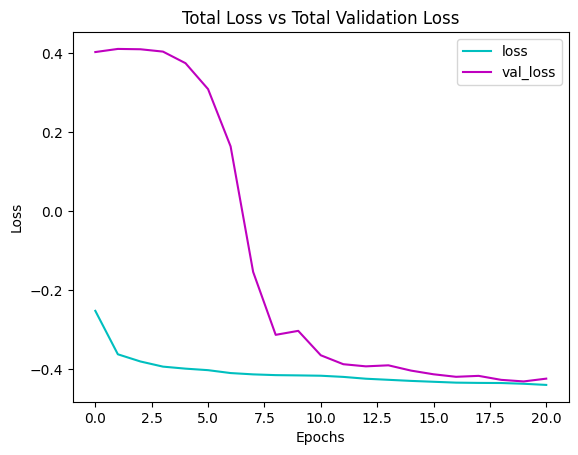

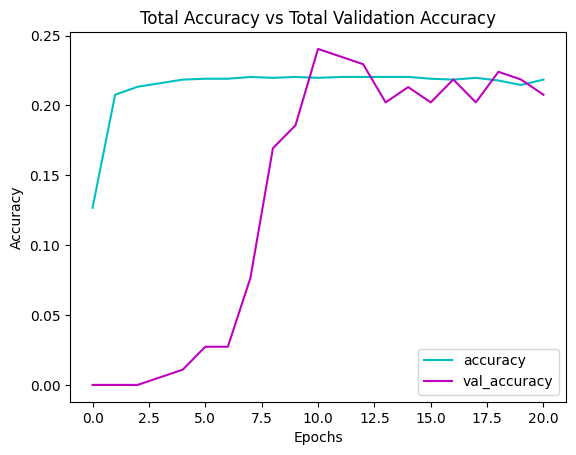

In [53]:
# visualizing the training and validation loss metrices
plot_metric(hist, 'loss', 'val_loss',
            'Total Loss vs Total Validation Loss', 'Loss')

# visualizing the training and validation accuracy metrices
plot_metric(hist, 'accuracy', 'val_accuracy',
            'Total Accuracy vs Total Validation Accuracy', 'Accuracy')

### Saving the Model

The model achieved in the process is saved in a directory with current date and time along with the test loss and test accuracy. This allows retrieval of model that performed best for later predictions.

In [54]:
import datetime as dt

date_time_format = '%Y_%m_%d__%H_%M_%S' # the string date format.
current_date_time_dt = dt.datetime.now() # current Date and Time in a DateTime Object.
current_date_time_string = dt.datetime.strftime(
    current_date_time_dt, date_time_format) # convert the DateTime object to string according to the style mentioned in date_time_format string.

# naming system for model
model_file_name = f'ASL_Date_Time_{current_date_time_string}___Loss_{test_loss}___Accuracy_{test_accuracy}.h5'
model_file_path = main_path + 'model/'
os.makedirs(model_file_path, exist_ok=True)

# saving the model
model.save(model_file_path + f'{model_file_name}')

C:\Users\user\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\keras\src\engine\training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


# Model Analysis

### Confusion Matrix

**Finding Predicted Labels From Word Vectors**

The encoded labels are loaded from the compressed npz `labels.npz` file. A `cosine_similarity` function is defined to calculate cosine similarity between two word vectors. 

`find_predicted_labels` calculates the predicted labels based on cosine similiarity with the actual label vectors. The label vector that produces the highest similarity score is chosen as the predicted label word. 

`find_actual_label` is used to create a list of the actual label words.

Only 50 predicted and actual labels are chosen for better visualization. These are then printed to show the difference between the labels.

In [55]:
labels_dict = np.load(main_path + f'labels_{len(labels)}.npz', allow_pickle=True)

In [56]:
def cosine_similarity(v1, v2):
    return np.dot(v1, v2) / (np.linalg.norm(v1) * np.linalg.norm(v2))

In [57]:
def find_predicted_label(target_word_vector):
    most_similar_label = None
    max_similarity = -1  # initializing with a value less than possible similarity

    for label, word_vector in labels_dict.items():
        similarity = cosine_similarity(target_word_vector, word_vector)

        # updating if the current word vector is more similar
        if similarity > max_similarity:
            max_similarity = similarity
            most_similar_label = label

    if most_similar_label is not None:
        return most_similar_label
    else:
        return None

In [58]:
def find_actual_label(actual_word_vector):
    found_label = None
    for label, word_vector in labels_dict.items():
        if np.array_equal(word_vector, actual_word_vector):
            found_label = label
            break

    if found_label is not None:
        return found_label
    else:
        return None

In [59]:
predicted_labels = []
actual_labels = []

predicted_vectors = model.predict(X_test)

# for the first 50 elements
for predicted_vector, actual_vector in tqdm(zip(predicted_vectors[:50], Y_test[:50]), total=50, desc="Processing vectors"):

    predicted_label = find_predicted_label(predicted_vector)
    actual_label = find_actual_label(actual_vector)

    predicted_labels.append(predicted_label)
    actual_labels.append(actual_label)

5/5 [==============================] - 1s 39ms/step


Processing vectors:  16%|█▌        | 8/50 [00:00<00:02, 15.39it/s]

Processing vectors: 100%|██████████| 50/50 [00:02<00:00, 19.01it/s]


In [60]:
print("Predicted Labels:")
print(predicted_labels)

print("Actual Labels:")
print(actual_labels)

Predicted Labels:
['book', 'book', 'man', 'book', 'book', 'book', 'white', 'book', 'book', 'man', 'book', 'book', 'man', 'book', 'all', 'book', 'book', 'white', 'book', 'book', 'book', 'book', 'man', 'book', 'man', 'book', 'book', 'book', 'book', 'book', 'book', 'like', 'book', 'book', 'book', 'white', 'book', 'man', 'book', 'book', 'man', 'white', 'man', 'man', 'book', 'book', 'book', 'book', 'all', 'book']
Actual Labels:
['later', 'later', 'man', 'man', 'shirt', 'shirt', 'shirt', 'study', 'study', 'tall', 'tall', 'tall', 'white', 'white', 'before', 'before', 'before', 'before', 'chair', 'chair', 'chair', 'book', 'go', 'book', 'go', 'go', 'clothes', 'book', 'clothes', 'clothes', 'who', 'who', 'who', 'candy', 'candy', 'candy', 'cousin', 'book', 'cousin', 'cousin', 'deaf', 'deaf', 'deaf', 'fine', 'fine', 'fine', 'help', 'help', 'help', 'no']


**Plotting confusion matrix**

Using the actual and predicted labels obtained, a confusion matrix is plotted to visualize the perfomance of the model.

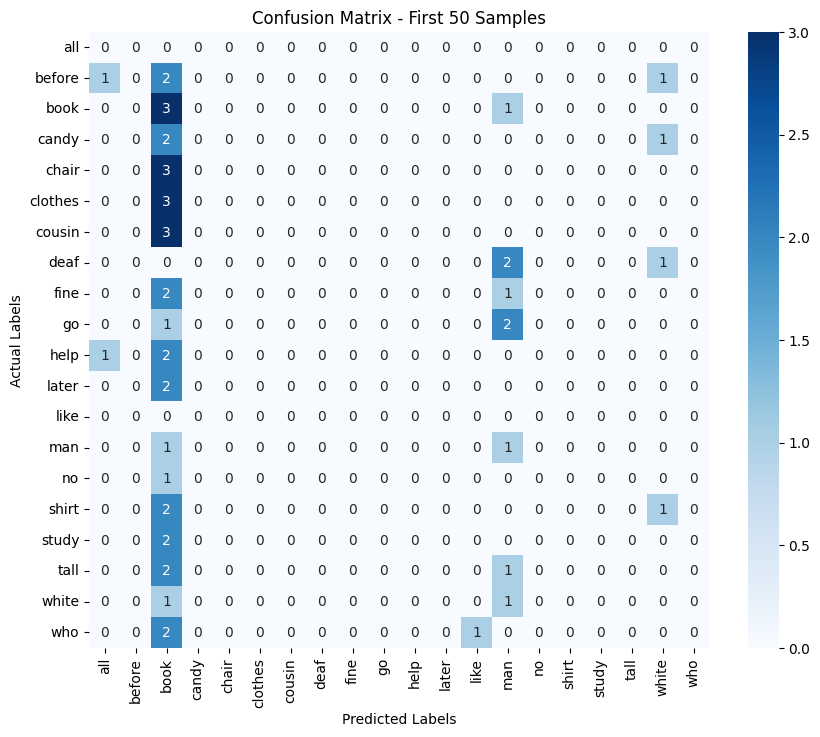

In [61]:
conf_matrix = confusion_matrix(actual_labels, predicted_labels)

# Concatenating unique labels from actual and predicted
unique_labels = np.unique(np.concatenate([actual_labels, predicted_labels]))

# plotting the confusion matrix
plt.figure(figsize=(10, 8))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues", xticklabels=unique_labels,
            yticklabels=unique_labels)
plt.title("Confusion Matrix - First 50 Samples")
plt.xlabel("Predicted Labels")
plt.ylabel("Actual Labels")
plt.show()


### ROC and AUC

ROC and AUC is plotted to visualize the performance of model. `label_binarize` is used to binarize the actual and predicted labels. Each word/class is iterated to produce FPR and TPR to plot the ROC curve. 

ROC curves for the classes are plotted on the same graph for comparison and  the legends are used to display the ROC area for each word. 

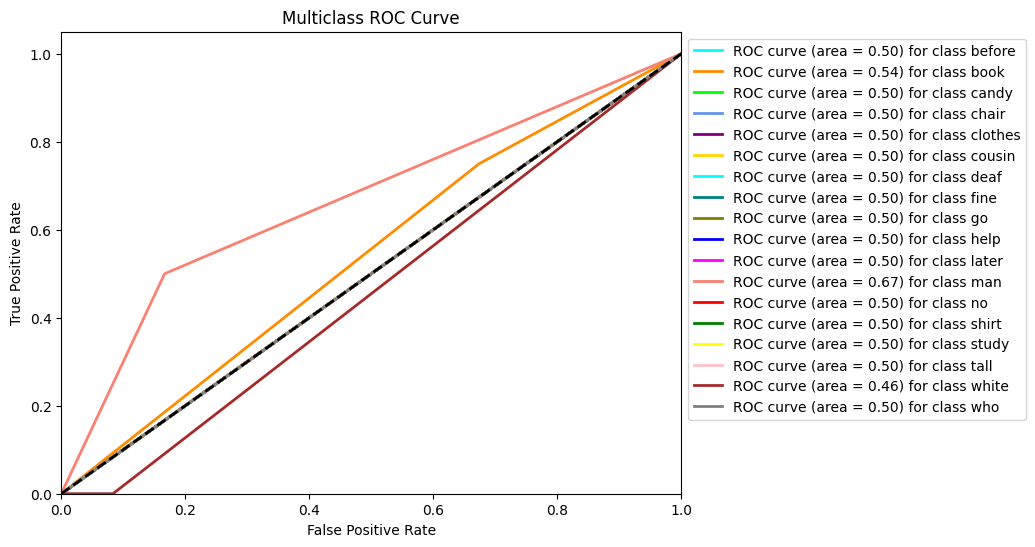

In [62]:
# binarizing the labels
classes = np.unique(actual_labels)
y_true = label_binarize(actual_labels, classes=classes)
y_score = label_binarize(predicted_labels, classes=classes)

# computing ROC curve and ROC area for each class
fpr = dict()
tpr = dict()
roc_auc = dict()

n_classes = len(classes)
for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(y_true[:, i], y_score[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# plotting
plt.figure(figsize=(8, 6))
colors = cycle(['aqua', 'darkorange', 'lime', 'cornflowerblue', 'purple', 'gold', 'cyan', 'teal',
                'olive',  'blue', 'magenta', 'salmon', 'red', 'green', 'yellow', 'pink', 'brown', 'gray'])
for i, color in zip(range(n_classes), colors):
    plt.plot(fpr[i], tpr[i], color=color, lw=2,
             label='ROC curve (area = {:.2f}) for class {}'.format(roc_auc[i], classes[i]))

plt.plot([0, 1], [0, 1], 'k--', lw=2)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Multiclass ROC Curve')
plt.legend(loc="upper left", bbox_to_anchor=(1, 1))
plt.show()